In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf

from src.DataPreprocessor.data_preprocessor import DataPreprocessor, Mode
from src.LearningKeras.net_architecture import cnn_150x150x5_3class, cnn_150x150x5_3class_5convolutions
from src.LearningKeras.train import KerasTrainer

from tqdm import trange

np.random.seed(1)
tf.set_random_seed(2)

In [2]:
from src.DataPreprocessor.DataIOBackend.gdal_backend import GdalBackend
from src.DataPreprocessor.PatchesOutputBackend.in_memory_backend import InMemoryBackend
from src.DataPreprocessor.data_visualiser import DataVisualiser

dataiobackend = GdalBackend()
data_preprocessor = DataPreprocessor(data_dir="data/Region 1 - Lopukangri/",
                              data_io_backend=dataiobackend,
                              patches_output_backend = InMemoryBackend(),
                              filename_prefix="tibet",
                              mode=Mode.TRAIN,
                              seed=1)

In [3]:
model_generator = lambda: cnn_150x150x5_3class()
ensemble_size = 1
batch_size = 5

trainer = KerasTrainer(model_generator=model_generator,
                       ensemble_size=ensemble_size)
train_generator = data_preprocessor.train_generator_3class(batch_size=batch_size,
                                         class_probabilities=[0.33, 0.33, 0.33],
                                         patch_size=(150, 150),
                                         channels=[0, 1, 2, 3, 4])

In [4]:
trainer.load('scripts/3class_training_trained_models_1')

In [5]:
layer_dict = dict([(layer.name, layer) for layer in trainer.models[0].layers])

In [6]:
input_img = trainer.models[0].input

In [7]:
 step = 0.001

In [8]:
layer_dict

{'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f2b8fc115f8>,
 'activation': <tensorflow.python.keras.layers.core.Activation at 0x7f2be935ec18>,
 'max_pooling2d': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x7f2b8c048e10>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f2b78495748>,
 'activation_1': <tensorflow.python.keras.layers.core.Activation at 0x7f2b783fa390>,
 'max_pooling2d_1': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x7f2b783fa438>,
 'flatten': <tensorflow.python.keras.layers.core.Flatten at 0x7f2b783fa470>,
 'dense': <tensorflow.python.keras.layers.core.Dense at 0x7f2b78409e48>,
 'activation_2': <tensorflow.python.keras.layers.core.Activation at 0x7f2b783b8390>,
 'dropout': <tensorflow.python.keras.layers.core.Dropout at 0x7f2b783b8208>,
 'dense_1': <tensorflow.python.keras.layers.core.Dense at 0x7f2b783b8b00>,
 'activation_3': <tensorflow.python.keras.layers.core.Activation at 0x7f2b783b8828>}

In [9]:
img_width = 25
img_height = 25

layer names may increment after rerunning cells

In [23]:
layer_name = 'conv2d'
filter_index = 20  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = tf.keras.backend.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = tf.keras.backend.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = tf.keras.backend.function([input_img], [loss, grads])

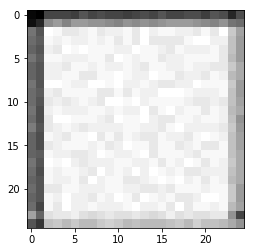

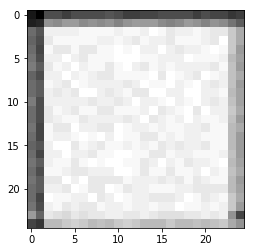

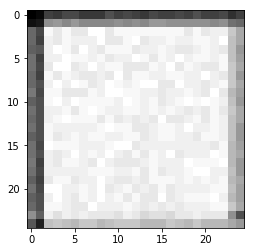

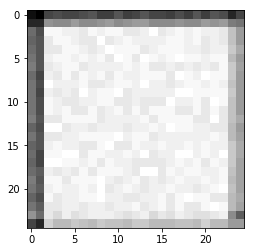

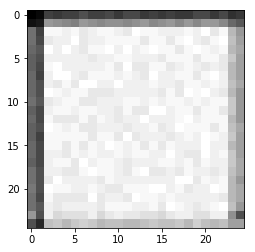

In [25]:
# we start from a gray image with some noise
for filter_index in range(5):
    input_img_data = np.random.random((1, img_width, img_height, 5))
    # run gradient ascent for 20 steps
    #loss_values = []
    for i in range(10000):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        #loss_values.append(loss_value)

    img = input_img_data[0]
    img = deprocess_image(img)
    plt.imshow(img[:, :, 4], cmap='gray')
    plt.show()

In [16]:
#plt.plot(loss_values)

In [13]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    #x = x.astype('uint8')
    return x
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

In [ ]:
img = input_img_data[0]
img = deprocess_image(img)

In [ ]:
plt.imshow(img[:, :, :3])

In [ ]:
plt.imshow(img[:, :, 3])

In [ ]:
plt.imshow(img[:, :, 4])